In [1]:
# Standard packages for data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

# numpy lets us handle numeric arrays efficiently
import numpy as np

# pandas handles tabular data
import pandas as pd

# networkx handles network data
import networkx as nx

# To run queries against MediaWiki APIs
import wikitools as wt

# json handles reading and writing JSON data
import json

# To parse links out of HTML markup in Wikipedia pages
from bs4 import BeautifulSoup

# Some other helper functions
from collections import Counter
from operator import itemgetter

C:\Users\bkeegan\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
def extract_query_to_list(json, stuff, key):
    l = []
    pageid = str(json['query']['pages'].keys()[0])
    if stuff in json['query']['pages'][pageid]:
        for item in json['query']['pages'][pageid][stuff]:
            if key:
                l.append(item[key])
            else:
                l.append(item)
    return l

def wikipedia_query(wiki,params,stuff,key):
    """ Perform a query on a 'wiki' endpoint, with a dictionary of parameters, that returns results keyed by 'stuff'
    """
    # Make the query
    results = wt.api.APIRequest(wiki=wiki,data=params).queryGen()
    
    # The results are a generator, so we need to catch the data
    result_list = []
    for result in results:
        result_list += extract_query_to_list(result,stuff,key)
        
    return result_list

def get_revision_df(article):
    revisions_query = {'action': 'query',
                      'redirects': 'True',
                      'prop': 'revisions',
                      'titles': article,
                      'rvprop': 'ids|user|timestamp|user|userid|comment|size',
                      'rvlimit': '500',
                      'rvdir': 'newer'}

    revisions_data = wikipedia_query(enwp,revisions_query,'revisions',None)

    # Extract and convert to DataFrame. Try/except for links to pages that don't exist
    try:
        df = pd.DataFrame(revisions_data)
        
        # Make it clear what's being edited
        df['page'] = article

        # Clean up timestamps
        df['timestamp'] = pd.to_datetime(df['timestamp'],format="%Y-%m-%dT%H:%M:%SZ",unit='s')

        # Clean up anon column. If/else for articles that have all non-anon editors
        if 'anon' in df.columns:
            df = df.replace({'anon':{np.nan:False,u'':True}})
        else:
            df['anon'] = False

        # Sort the data on timestamp and reset the index
        df = df.sort_values('timestamp').reset_index(drop=True)
        df.index.name = 'revision'
        df = df.reset_index()

        # Set the index to a MultiIndex
        #df.set_index(['page','revision'],inplace=True)

        # Compute additional features
        df['date'] = df['timestamp'].apply(lambda x:x.date())
        df['diff'] = df['size'].diff()
        df['latency'] = df['timestamp'].diff().apply(lambda x:round(x/np.timedelta64(1,'s'),-1) + 1)

        # Don't return random other columns
        df = df[[u'anon',u'comment',u'parentid',u'revid',u'size',u'timestamp',
                 u'revision',u'user',u'userid',u'date', u'diff', u'latency','page']]

        return df
        
    except KeyError:
        print u"{0} doesn't exist!".format(article)
        pass
    
enwp = wt.wiki.Wiki(url='https://en.wikipedia.org/w/api.php')

In [18]:
merrick_garland_df = get_revision_df('Merrick Garland')
merrick_garland_df.tail()

,anon,comment,parentid,revid,size,timestamp,revision,user,userid,date,diff,latency,page
528,False,added important case,710640972,710655511,33101,2016-03-18 06:44:11,528,Bangabandhu,8642534,2016-03-18,1163.0,8401.0,Merrick Garland
529,False,"/* Service on the D.C. Circuit, reputation, an...",710655511,710655639,33107,2016-03-18 06:45:47,529,Bangabandhu,8642534,2016-03-18,6.0,101.0,Merrick Garland
530,False,"/* Service on the D.C. Circuit, reputation, an...",710655639,710657325,33108,2016-03-18 07:07:16,530,Bangabandhu,8642534,2016-03-18,1.0,1291.0,Merrick Garland
531,False,"/* Service on the D.C. Circuit, reputation, an...",710657325,710657484,33147,2016-03-18 07:09:08,531,Bangabandhu,8642534,2016-03-18,39.0,111.0,Merrick Garland
532,False,/* Personal life */,710657484,710658034,33573,2016-03-18 07:16:28,532,Bangabandhu,8642534,2016-03-18,426.0,441.0,Merrick Garland


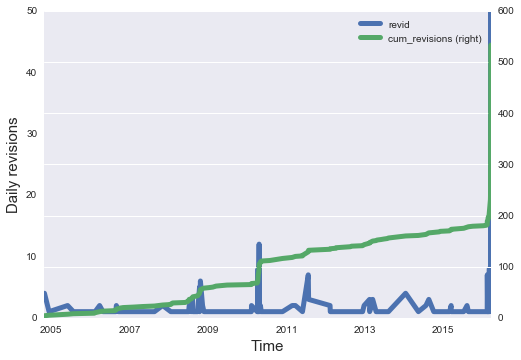

In [9]:
activity_by_day = merrick_garland_df.groupby('date').aggregate({'revid':len})
activity_by_day['cum_revisions'] = activity_by_day['revid'].cumsum()

ax = activity_by_day.plot(lw=5,secondary_y=['cum_revisions'])
#patches, labels = ax.get_legend_handles_labels()
#ax.legend(patches, labels, loc='center left',bbox_to_anchor=(1,.5))

ax.set_ylim((0,50))
ax.set_ylabel('Daily revisions',fontsize=15)
ax.set_xlabel('Time',fontsize=15)

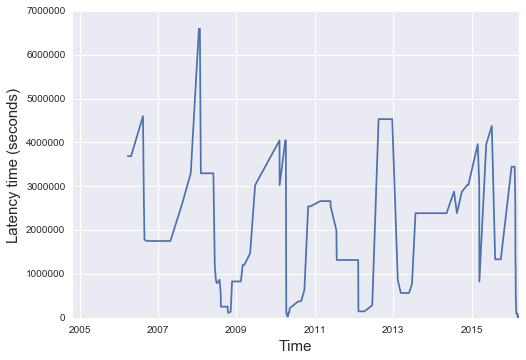

In [16]:
activity_by_day = merrick_garland_df.groupby('date').aggregate({'revid':len,
                                                       'diff':np.median,
                                                       'latency':np.median})

# Compute a 28-day rolling average to remove spikiness, plot
activity_by_day['latency'].rolling(window=7).median().plot()
#plt.yscale('symlog')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Latency time (seconds)',fontsize=15)

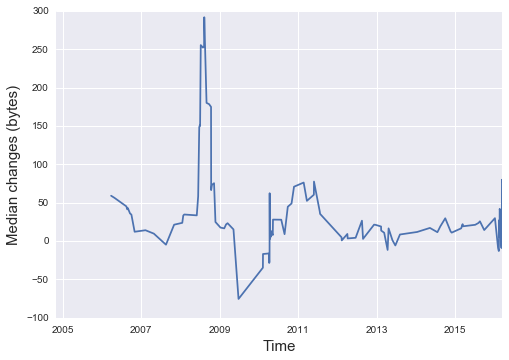

In [15]:
# Compute a 56-day rolling average to remove spikiness, plot
activity_by_day['diff'].rolling(window=7).mean().plot()
#plt.yscale('symlog')
plt.xlabel('Time',fontsize=15)
plt.ylabel('Median changes (bytes)',fontsize=15)

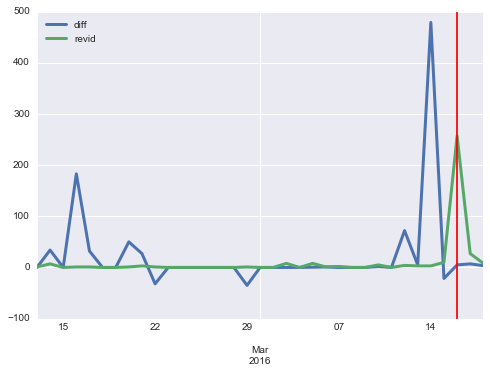

In [29]:
ax = activity_by_day.ix[pd.date_range('2016-02-13','2016-03-18'),['diff','revid']].fillna(0).plot(lw=3)
ax.axvline(pd.to_datetime('2016-03-16'),color='r')

In [51]:
_start_date = pd.datetime(2016,3,12).date()
_end_date = pd.datetime(2016,3,15).date()
merrick_garland_df[(merrick_garland_df['date'] > _start_date) & (merrick_garland_df['date'] < _end_date)]

,anon,comment,parentid,revid,size,timestamp,revision,user,userid,date,diff,latency,page
225,False,"/* Early life, education and legal training */",709764373,709871807,11712,2016-03-13 16:27:47,225,Bender235,88026,2016-03-13,5.0,61961.0,Merrick Garland
226,False,,709871807,709871872,11711,2016-03-13 16:28:34,226,Bender235,88026,2016-03-13,-1.0,51.0,Merrick Garland
227,False,/* Professional career */,709871872,709872010,11719,2016-03-13 16:29:49,227,Bender235,88026,2016-03-13,8.0,81.0,Merrick Garland
228,False,"Expand, futureproof reference",709872010,710020622,12000,2016-03-14 13:52:51,228,LLarson,46261,2016-03-14,281.0,76981.0,Merrick Garland
229,False,"Expand, futureproof reference",710020622,710022633,12505,2016-03-14 14:09:48,229,LLarson,46261,2016-03-14,505.0,1021.0,Merrick Garland
230,False,,710022633,710084453,12984,2016-03-14 21:37:49,230,Bender235,88026,2016-03-14,479.0,26881.0,Merrick Garland


In [ ]:
https://en.wikipedia.org/w/index.php?title=Merrick_Garland&type=revision&diff=710217001&oldid=709872010